In [66]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

In [88]:
def generate_samples_and_labels(
    num_samples: int,
    mean: np.ndarray,
    covariance: np.ndarray,
    theta: np.ndarray,
    label_variance: float,
    seed=42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate samples and corresponding labels from a multivariate Gaussian distribution.

    Args:
        num_samples (int): Number of samples to generate.
        mean (np.ndarray): Mean vector of the multivariate Gaussian distribution.
        covariance (np.ndarray): Covariance matrix of the multivariate Gaussian distribution.
        theta (np.ndarray): Coefficient vector for generating labels.
        label_variance (float): Variance of the Gaussian noise added to the labels.
        seed (int): Seed for the random number generator.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the generated samples and labels.
    """
    if seed is not None:
        np.random.seed(seed)

    X = np.random.multivariate_normal(mean, covariance, num_samples)

    y = X @ theta + np.random.normal(0, label_variance, num_samples)

    return X, y

In [92]:
# Mean vector and covariance matrix for initial sampling
mean = np.array([0, 0])
covariance = np.array([[1, 0], [0, 1]])
num_samples = 20

# Theta vector
theta = np.array([-1, 1])

# Variance for the label distribution
label_variance = 0.1

X, y = generate_samples_and_labels(
    num_samples, mean, covariance, theta, label_variance, seed=42
)


## Posterior distribution

We can compute the posterior distribution using equation (55) and (56) in "PML Lecture Notes for Lectures by Oswin".

In [93]:
def posterior_distribution(covariance, X, y, label_variance):
    """
    Compute the posterior distribution of the weights given the samples.

    Args:
        covariance (np.ndarray): Covariance matrix of the multivariate Gaussian distribution.
        samples (np.ndarray): Samples for which to compute the posterior distribution.
        label_variance (float): Variance of the Gaussian noise added to the labels.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the mean and covariance of the posterior distribution.
    """

    mean_tmp = (
        covariance
        @ X.T
        @ (
            np.linalg.inv(
                label_variance * np.identity(num_samples) + X @ covariance @ X.T
            )
        )
    )
    posterior_mean = mean_tmp @ y

    posterior_covariance = covariance - mean_tmp @ X @ covariance

    return posterior_mean, posterior_covariance


In [94]:
# Posterior multivariate normal distribution
posterior_mean, posterior_covariance = posterior_distribution(
    covariance, X, y, label_variance
)
posterior = multivariate_normal(posterior_mean, posterior_covariance)


In [95]:
posterior_mean

array([-1.00755274,  1.01937033])

In [96]:
posterior_covariance

array([[ 6.40408632e-03, -2.82979721e-05],
       [-2.82979721e-05,  4.56579757e-03]])

In [97]:
# Grid ranges
x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(x, y)
grid = np.dstack((X, Y))
Z = posterior.pdf(grid)


In [98]:
# Contour plot
def plot_contour(X, Y, Z, title, file=None):
    cmap = "viridis"
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=50, cmap=cmap)
    plt.xlabel("X1-axis")
    plt.ylabel("X2-axis")
    # plt.title(title)
    plt.colorbar(label="Probability Density")
    if file is not None:
        plt.savefig(file, dpi=600)
    plt.show()

## Posterior predictive distribution

The posterior predictive distribution is given by equation (57) in "PML Lecture Notes for Lectures by Oswin".

In [99]:
def posterior_predictive(x, mean, cov):
    pp_mean = x @ mean
    pp_cov = x @ cov @ x.T + label_variance
    return pp_mean, pp_cov

## Plot variance for posterior predictive distribution

In [100]:
def posterior_predictive_variance(grid, cov, noise):
    """
    Calculate the posterior predictive variance for new data points in a Gaussian process regression model.

    Parameters:
    grid (numpy.ndarray): New data points for which the variance is being predicted.
                           Should be of shape (n_samples, n_samples, n_features).
    cov (numpy.ndarray): Covariance matrix of the Gaussian process.
                         Should be of shape (n_features, n_features).
    noise (float): Noise variance in the observations.

    Returns:
    numpy.ndarray: Posterior predictive variance for each new data point.
    """

    # The np.einsum function is used to perform an Einstein summation convention
    # operation. This operation allows for a concise and efficient way to perform
    # multi-dimensional array operations. Specifically, the expression '...i,ij,...j->...'
    # indicates that the function is performing a bilinear form calculation. It
    # multiplies X_new with the covariance matrix cov and then with X_new again,
    # summing over the appropriate indices. This results in a scalar value for each
    # new data point, representing the variance contribution from the covariance matrix.
    result = np.einsum("...i,ij,...j->...", grid, cov, grid)
    return result + noise

In [ ]:
ZZ = posterior_predictive_variance(grid, posterior_covariance, label_variance)


(1000, 1000)

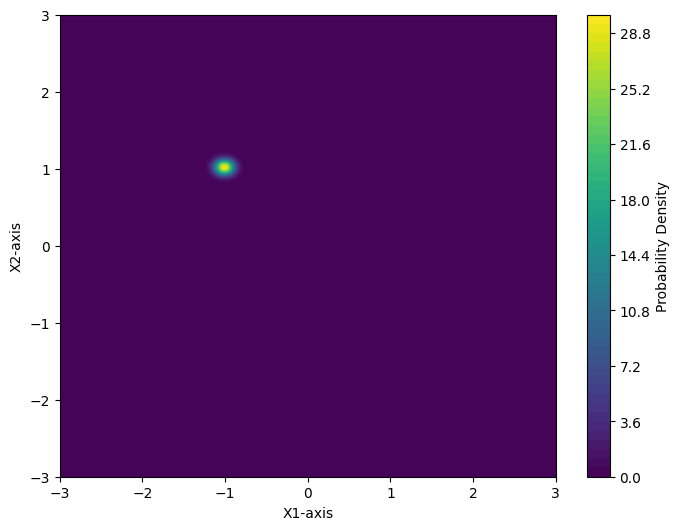

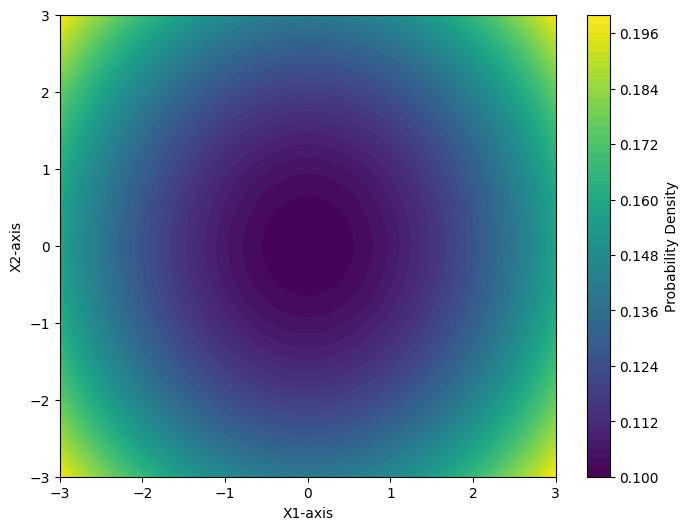

In [102]:
plot_contour(
    X, Y, Z, "2D Posterior Multivariate Gaussian Distribution", "posterior.png"
)
plot_contour(
    X, Y, ZZ, "Posterior Predictive Variance", "posterior_predictive_variance.png"
)

In [79]:
theta

array([-1,  1])

In [80]:
mean

array([0, 0])

In [110]:
covariance = np.array([[0.1, 0], [0, 1]])
label_variance = 0.1
X2, y2 = generate_samples_and_labels(
    num_samples=20,
    mean=mean,
    covariance=covariance,
    theta=theta,
    label_variance=label_variance,
    seed=42,
)

In [111]:
posterior_mean, posterior_covariance = posterior_distribution(
    covariance, X2, y2, label_variance
)


In [112]:
posterior_mean

array([-0.63330144,  0.97904079])

In [113]:
posterior_covariance

array([[ 3.14445846e-02, -6.16289150e-05],
       [-6.16289150e-05,  6.40403172e-03]])

In [114]:
posterior = multivariate_normal(posterior_mean, posterior_covariance)
Z = posterior.pdf(grid)

ZZ = posterior_predictive_variance(grid, posterior_covariance, label_variance)

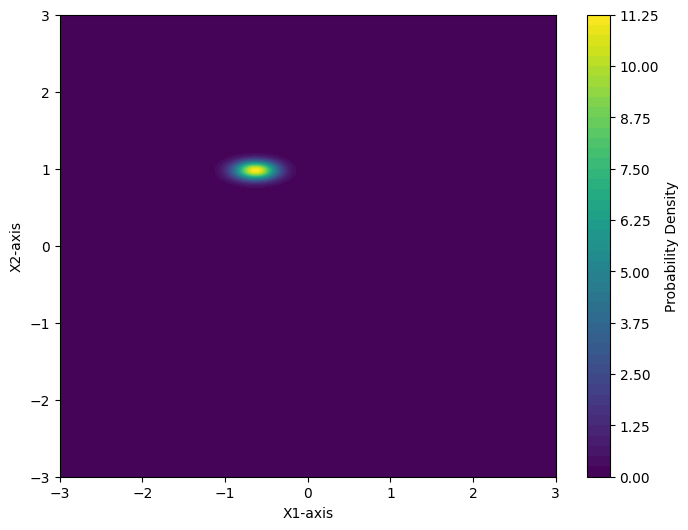

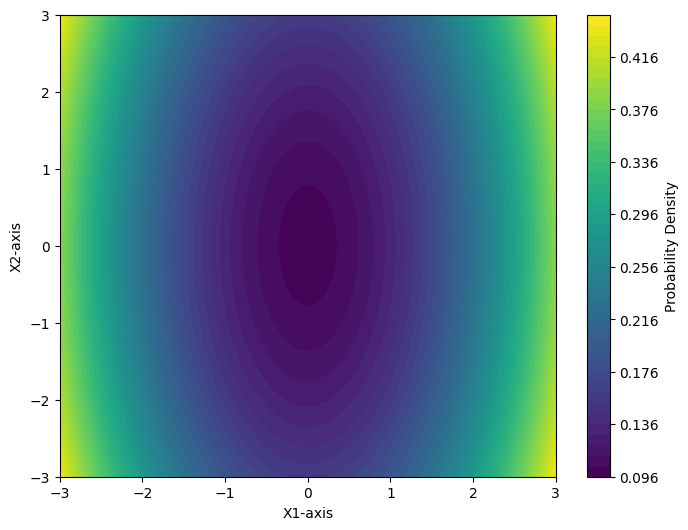

In [115]:
plot_contour(
    X, Y, Z, "2D Posterior Multivariate Gaussian Distribution", "posterior2.png"
)
plot_contour(
    X, Y, ZZ, "Posterior Predictive Variance", "posterior_predictive_variance2.png"
)

In [87]:
!jupyter nbconvert --to script code1.ipynb

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.
